# Global Volunteer Application Qualifier

### A Machine Learning model to identify application most likely to approve.

> This notebook is an study and exercise on data science pipeline and modeling, by João Diogo Brites



1. Importing packages and dataset
2. Selecting features and spliting dataset
3. Training XGBoost Model
4. K-fold Cross Validation (with and without time series)
5. Feature importance
6. ROC and P|R Curve
7. Recursive Feature Selection with Cross-Validation
8. Boruta Feature Selection
9. Log. Regression Model
- Next Steps
---

# 1. Importing packages and dataset

In [1]:
import os
import gc
import re
import sys
import traceback
import warnings
import datetime
from time import time

import seaborn as sns
from matplotlib import pyplot as plt


import numpy as np
import pandas as pd
pd.options.display.max_columns = None
#import lightgbm as lgb
import xgboost as xgb
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from category_encoders.target_encoder import TargetEncoder

from tqdm import tqdm_notebook
from IPython.display import display, HTML
import ds_utils

%load_ext autoreload
%autoreload 2

gc.enable()
warnings.filterwarnings("ignore")
np.random.seed(710105)

In [2]:
df = pd.read_csv("../Data/dataset_gv_v2.csv")

df.columns

Index(['approval', 'status', 'required_skills_percentage',
       'required_languages_percentage', 'required_backgrounds_percentage',
       'date_signup', 'month_signup', 'day_signup', 'abs_date_signup',
       'date_applied', 'month_applied', 'day_applied', 'abs_date_applied',
       'time_to_apply', 'host_lc', 'host_mc', 'program',
       'person_accepted_count', 'person_rejected_count',
       'person_applications_count', 'home_lc', 'home_mc',
       'profile_completeness_ge', 'profile_completeness_gv',
       'profile_completeness_gt', 'professional_experience_in_years',
       'english_level', 'spanish_level', 'latest_academic_level.name'],
      dtype='object')

# 2. Selecting features and spliting dataset

---

We differentiate types of data from our dataset because each one of them will need to be treated differently. This also makes it easier to remove and input variables.

- Numerical values dont always need encoding or normalization
- Categorical values must be encoded
- Boolean values mostly do not need encoding
- Date values are better used to generate other numerical variabler
- Target is our y

We split the dataset in a training and testing set, while also encoding categorical features

In [3]:
num_cols = [
 'required_skills_percentage',
 'required_languages_percentage',
 'required_backgrounds_percentage',
 'month_signup',
 'day_signup',
 'abs_date_signup',
 'month_applied',
 'day_applied',
 'abs_date_applied',
 'time_to_apply',
 'person_accepted_count',
 'person_rejected_count',
 'person_applications_count',
 'professional_experience_in_years',
 'english_level',
 'spanish_level',
]
cat_cols = [
 'host_lc',
 'host_mc',
# 'program',
 'home_lc',
# 'home_mc',
 'latest_academic_level.name'
]
bool_cols = [
 'profile_completeness_ge',
 'profile_completeness_gv',
 'profile_completeness_gt',
]
date_cols = [
 'date_signup',
 'date_applied',
]
target = "approval"

In [4]:
X = df[num_cols+bool_cols+cat_cols]
y = df[target]

In [5]:
#split sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [6]:
# Label Encoding
for f in X.columns:
    if X_train[f].dtype=='object' or X_test[f].dtype=='object':
        X_train[f] = X_train[f].fillna('NA')
        X_test[f] = X_test[f].fillna('NA')
        te = TargetEncoder(smoothing=10, min_samples_leaf=100)
        te.fit(X_train[f],y_train)
        X_train[f] = te.transform(X_train[f])
        X_test[f] = te.transform(X_test[f])

# 3. Training XGBoost Classifier

---

In this example we are using XGBoost. XGBoost is an implementation of gradient boosted decision trees. It is a focused choice that allows better model performance and faster execution when compared to sklearn Random Forest

In [7]:
params = {
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary:logistic',
          'max_depth': 6,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          "nrounds":200
         }

In [8]:
#train model

clf = xgb.XGBClassifier(**params)
_ = clf.fit(X_train, y_train)

In [15]:
y_pred_clf = clf.predict(X_test)

In [14]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_clf)

# 4. K-fold Cross Validation (with and without time series)

---
K-fold Cross Validation split the defined set in k parts (folds). Uses these folds to train a model and test the rest of the data set accordingly. This results in an array of the desired scoring for these folds. In this example we are using "roc_auc", but other models may use "accuracy", for example. The average and standard of the k-fold CV **can show us how resilient our model is to futuro data**. Plotting the ROC couve of all these folds can help us better visualize the models consistency.

This diagram shows the process for k = 5



<img src="kfold.png">


In the case of time series, besides the function used, it is important to order the dataset accordingly. if random, the CV will approach the value of the non-time serialized CV.

In [ ]:
# k-fold cross-validation

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

kf = KFold(n_splits=10) 

cv_scores = cross_val_score(clf,X_train,y_train,scoring = "roc_auc",cv=kf)
print("perda: {0:.3f} (+/- {1:.3f})".format(cv_scores.mean(), cv_scores.std()))

In [ ]:
kf = KFold(n_splits=5)

tprs,fprs,aucs = [],[],[]




for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    # Label Encoding
    for f in X.columns:
        if X_train[f].dtype=='object' or X_test[f].dtype=='object':
            X_train[f] = X_train[f].fillna('NA')
            X_test[f] = X_test[f].fillna('NA')
            te = TargetEncoder(smoothing=10, min_samples_leaf=100)
            te.fit(X_train[f],y_train)
            X_train[f] = te.transform(X_train[f])
            X_test[f] = te.transform(X_test[f])
    clf = xgb.XGBClassifier(**params)
    _ = clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    auc = metrics.auc(fpr, tpr)
    tprs += [tpr]
    fprs += [fpr]
    aucs += [auc]
    

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(14, 6)
#ROC 
#f = plt.figure(1)
ax1.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'grey')

for i in range(5):
    ax1.plot(fprs[i], tprs[i], color='blue',
             label=r'Fold 1 ROC (AUC = %0.4f)' % (aucs[i]),lw=2, alpha=1)

ax1.set_xlabel('Índice de Falsos Positivos')
ax1.set_ylabel('Índice de Verdadeiros Positivos')
ax1.set_title('Média da ROC')
ax1.legend(loc="lower right")

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

tprs,fprs,aucs = [],[],[]




for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    # Label Encoding
    for f in X.columns:
        if X_train[f].dtype=='object' or X_test[f].dtype=='object':
            X_train[f] = X_train[f].fillna('NA')
            X_test[f] = X_test[f].fillna('NA')
            te = TargetEncoder(smoothing=10, min_samples_leaf=100)
            te.fit(X_train[f],y_train)
            X_train[f] = te.transform(X_train[f])
            X_test[f] = te.transform(X_test[f])
    clf = xgb.XGBClassifier(**params)
    _ = clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    auc = metrics.auc(fpr, tpr)
    tprs += [tpr]
    fprs += [fpr]
    aucs += [auc]
    
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(14, 6)
#ROC 
#f = plt.figure(1)
ax1.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'grey')

for i in range(5):
    ax1.plot(fprs[i], tprs[i], color='blue',
             label=r'Fold 1 ROC (AUC = %0.4f)' % (aucs[i]),lw=2, alpha=1)

ax1.set_xlabel('Índice de Falsos Positivos')
ax1.set_ylabel('Índice de Verdadeiros Positivos')
ax1.set_title('Média da ROC')
ax1.legend(loc="lower right")

In [ ]:
#timeseries kfold

from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=10)
tscv_scores = cross_val_score(clf, X_train, y_train, cv=tscv, scoring='roc_auc')
print("Perda: {0:.3f} (+/- {1:.3f})".format(tscv_scores.mean(), tscv_scores.std()))

# 5. Feature importance

---

Here we are ranking every feature in the model according to its importance. Feature importance is calculated as the decrease in node impurity weighted by the probability of reaching that node. The node probability can be calculated by the number of samples that reach the node, divided by the total number of samples. The higher the value the more important the feature

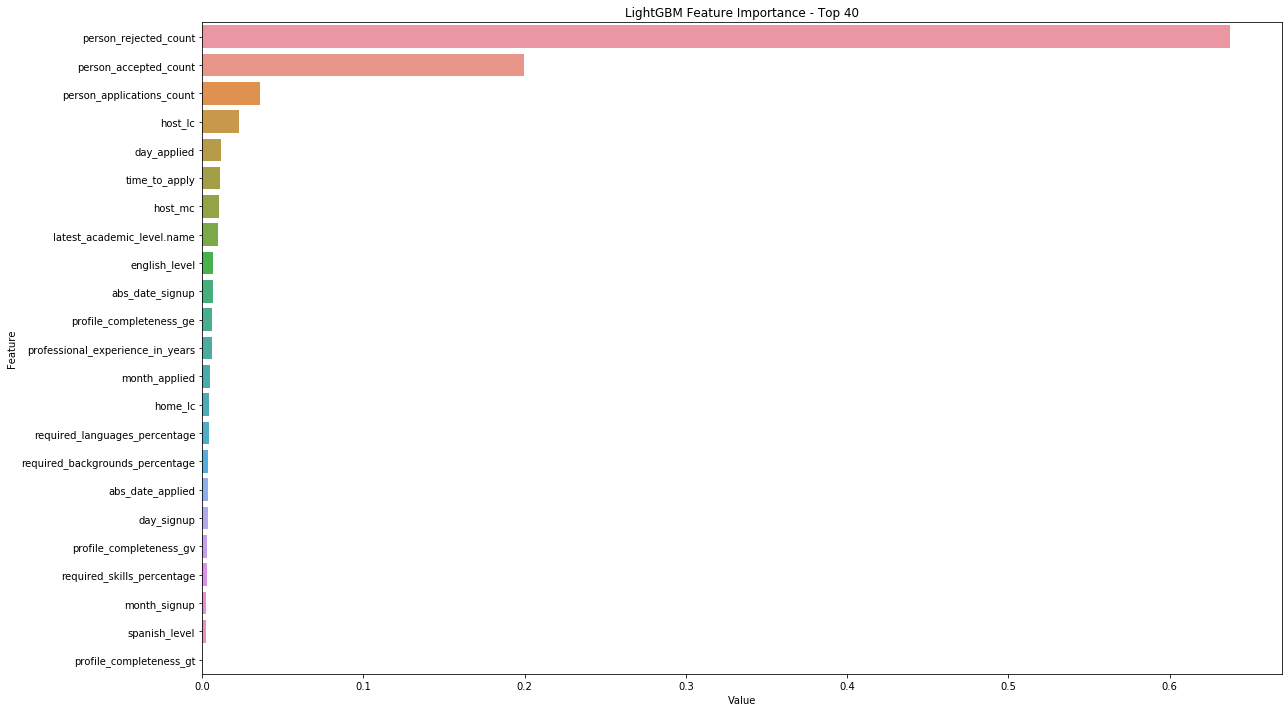

In [19]:
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(18, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:40])
plt.title('LightGBM Feature Importance - Top 40')
plt.tight_layout()
plt.show()
#plt.savefig('lgbm_importances.png')

# 6. ROC and P|R Curve

In [22]:
y_pred = clf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fpr, tpr)
precision, recall, th = metrics.precision_recall_curve(y_test, y_pred)

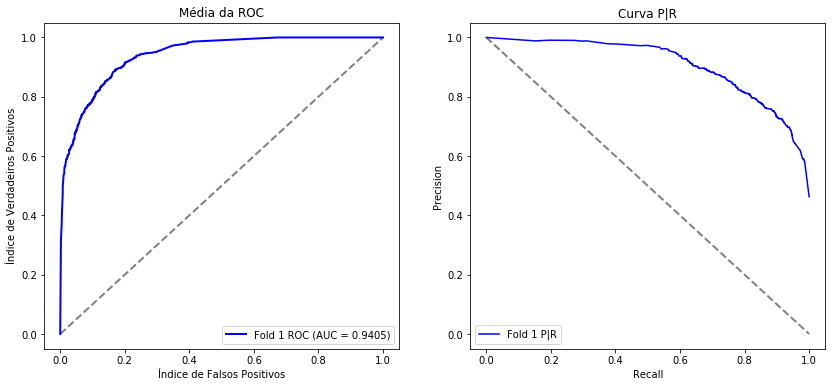

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(14, 6)
#ROC 
#f = plt.figure(1)
ax1.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'grey')

ax1.plot(fpr, tpr, color='blue',
         label=r'Fold 1 ROC (AUC = %0.4f)' % (auc),lw=2, alpha=1)

ax1.set_xlabel('Índice de Falsos Positivos')
ax1.set_ylabel('Índice de Verdadeiros Positivos')
ax1.set_title('Média da ROC')
ax1.legend(loc="lower right")

# PR plt
#g = plt.figure(2)
ax2.plot([0,1],[1,0],linestyle = '--',lw = 2,color = 'grey')

ax2.plot(recall, precision, color='blue',
         label=r'Fold 1 P|R')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Curva P|R')
_ = ax2.legend(loc="lower left")

# 7. RFE w/ Cross Validation

---

Recurseive Feature Elimination measure the loss in Cross Validation score (AUC) by the removal of the feature with the least importance. it itereates in that to suggest an optimal number of features

Here we are plotting the effect of n variables, then listing the optimal number of features suggested.

In [24]:
# RFE with Cross Validation to get optimal number f

from sklearn.feature_selection import RFECV

rfecv = RFECV(estimator=clf, step=1, cv=5,
              scoring='roc_auc')
rfecv.fit(X_train, y_train)

RFECV(cv=5,
      estimator=XGBClassifier(bagging_fraction=0.4181193142567742,
                              bagging_seed=11, base_score=0.5, booster='gbtree',
                              boosting_type='gbdt', colsample_bylevel=1,
                              colsample_bynode=1, colsample_bytree=1,
                              feature_fraction=0.3797454081646243, gamma=0,
                              learning_rate=0.006883242363721497,
                              max_delta_step=0, max_depth=6, metric='auc',
                              min_child_weight=0.03454472573214212,
                              min_data_in_leaf=106, missing=None,
                              n_estimators=100, n_jobs=1, nrounds=200,
                              nthread=None, objective='binary:logistic',
                              random_state=0, reg_alpha=0.3899927210061127,
                              reg_lambda=0.6485237330340494, scale_pos_weight=1,
                              seed=None, sile

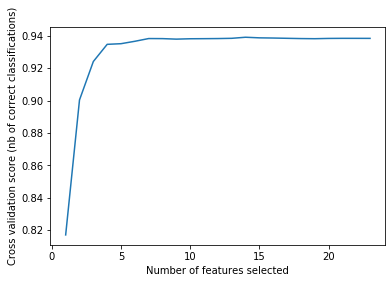

Optimal number of features : 14


In [25]:
#RFECV Viz

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

print("Optimal number of features : %d" % rfecv.n_features_)

In [26]:
#RFECV Feature List

features = [f for f in X.columns if f not in ['TARGET','SK_ID_CURR']]

rfecv_features = list()
indexes = np.where(rfecv.support_ == True)
for x in np.nditer(indexes):
    rfecv_features.append(features[x])
print(rfecv_features)

['required_languages_percentage', 'abs_date_signup', 'day_applied', 'abs_date_applied', 'time_to_apply', 'person_accepted_count', 'person_rejected_count', 'person_applications_count', 'professional_experience_in_years', 'english_level', 'profile_completeness_ge', 'host_lc', 'host_mc', 'latest_academic_level.name']


# 8. Boruta Feature Selection

---

Boruta is a R library adapted to python with BorutaPy. It randomizes all data in a dataset, then measure features importance of each feature for each randomization a determined number of times. Then it ranks features according to the loss that randomization of the feature caused in the selected scoring system, then eliminates it.

In [27]:
from boruta import BorutaPy

boruta = BorutaPy(estimator=clf, n_estimators='auto')
boruta.fit(X_train.values, y_train.values)

BorutaPy(alpha=0.05,
         estimator=XGBClassifier(bagging_fraction=0.4181193142567742,
                                 bagging_seed=11, base_score=0.5,
                                 booster='gbtree', boosting_type='gbdt',
                                 colsample_bylevel=1, colsample_bynode=1,
                                 colsample_bytree=1,
                                 feature_fraction=0.3797454081646243, gamma=0,
                                 learning_rate=0.006883242363721497,
                                 max_delta_step=0, max_depth=6, metric='auc',
                                 min_child_weight=0.034...
                                 min_data_in_leaf=106, missing=None,
                                 n_estimators=66, n_jobs=1, nrounds=200,
                                 nthread=None, objective='binary:logistic',
                                 random_state=250692155,
                                 reg_alpha=0.3899927210061127,
                    

In [28]:
#Boruta feature list

features = [f for f in X.columns if f not in ['TARGET','SK_ID_CURR']]

boruta_features = list()
indexes = np.where(boruta.support_ == True)
for x in np.nditer(indexes):
    boruta_features.append(features[x])
print(boruta_features)

['time_to_apply', 'person_accepted_count', 'person_rejected_count', 'person_applications_count', 'host_lc', 'host_mc', 'latest_academic_level.name']


# 9. Logistic Regression

---

INSERT DESCRIPTION

In [17]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(random_state = 0)
log_clf.fit(X_train, y_train)


y_pred_log = log_clf.predict(X_test)

In [35]:
fpr_log, tpr_log, thresholds_log = metrics.roc_curve(y_test, y_pred_log)
auc = metrics.auc(fpr_log, tpr_log)
precision, recall, th = metrics.precision_recall_curve(y_test, y_pred_log)

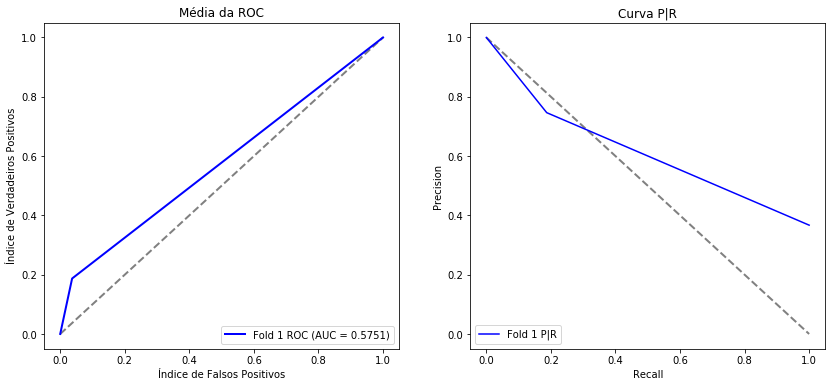

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(14, 6)
#ROC 
#f = plt.figure(1)
ax1.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'grey')

ax1.plot(fpr_log, tpr_log, color='blue',
         label=r'Fold 1 ROC (AUC = %0.4f)' % (auc),lw=2, alpha=1)

ax1.set_xlabel('Índice de Falsos Positivos')
ax1.set_ylabel('Índice de Verdadeiros Positivos')
ax1.set_title('Média da ROC')
ax1.legend(loc="lower right")

# PR plt
#g = plt.figure(2)
ax2.plot([0,1],[1,0],linestyle = '--',lw = 2,color = 'grey')

ax2.plot(recall, precision, color='blue',
         label=r'Fold 1 P|R')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Curva P|R')
_ = ax2.legend(loc="lower left")

# RFECV in the Logistic Regression

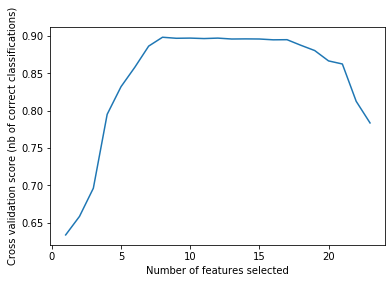

Optimal number of features : 8


In [39]:
# RFE with Cross Validation to get optimal number f
rfecv_log = RFECV(estimator=log_clf, step=1, cv=5,
              scoring='roc_auc')
rfecv_log.fit(X_train, y_train)

#RFECV Viz

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv_log.grid_scores_) + 1), rfecv_log.grid_scores_)
plt.show()

print("Optimal number of features : %d" % rfecv_log.n_features_)

In [40]:
#RFECV Feature List

features = [f for f in X.columns if f not in ['TARGET','SK_ID_CURR']]

rfecv_log_features = list()
indexes = np.where(rfecv_log.support_ == True)
for x in np.nditer(indexes):
    rfecv_log_features.append(features[x])
print(rfecv_log_features)

['person_accepted_count', 'person_rejected_count', 'profile_completeness_ge', 'profile_completeness_gv', 'host_lc', 'host_mc', 'home_lc', 'latest_academic_level.name']


# Forward Stepwise Selection

In [69]:
import stepwiseSelection as ss

final_features, iterations_logs = ss.forwardSelection(X_train,y_train, model_type="logistic")

Character Variables (Dummies Generated, First Dummies Dropped): []
Optimization terminated successfully.
         Current function value: 0.645750
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.644379
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.645072
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.645657
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.644918
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643862
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645742
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635747
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637777
         Iterations 5
Optimization te